# K-Nearest Neighbors (KNN) Classification Project

This project demonstrates the implementation and analysis of the k-Nearest Neighbors (kNN) algorithm, a non-parametric machine learning method for classification problems. The project explores the bias-variance tradeoff, hyperparameter selection, and model evaluation techniques using a synthetic voter party registration dataset.

## Project Overview

This project implements a k-Nearest Neighbors classifier from scratch and analyzes its behavior on synthetic data. The implementation includes:

1. **Custom KNN Classifier**: A complete implementation of the kNN algorithm with proper type hints and documentation
2. **Decision Boundary Analysis**: Visualization of how different k values affect model complexity and decision boundaries
3. **Hyperparameter Optimization**: Finding optimal k values using validation sets and cross-validation
4. **Bias-Variance Tradeoff**: Analysis of overfitting and underfitting behaviors

The project uses a synthetic voter party registration dataset where each voter is characterized by wealth and religiousness features, with labels representing party affiliation (Republican or Democrat).

**Note**: This project follows concepts from Scott Fortmann-Roe's work on bias-variance tradeoff (see references).

## k-Nearest Neighbors

The k-Nearest Neighbors (kNN) algorithm is a simple yet powerful non-parametric classification method. Given a labeled training set and a new sample, kNN predicts the label by:

1. Finding the k nearest neighbors in the training set (using a distance metric, typically Euclidean)
2. Using majority vote (for classification) or averaging (for regression) over the labels of these k neighbors

The algorithm is **non-parametric** because it doesn't learn fixed parameters during training—instead, it stores the entire training set and uses it directly for predictions.

kNN.png

## Implementation: KNN Classifier

This project implements a `KNNClassifier` class that follows the scikit-learn estimator interface. The implementation includes:

**Key Features:**
- **Data Representation**: Each data point is an n-dimensional point in $\mathbb{R}^n$, with binary labels (0 or 1)
- **Distance Metric**: Euclidean distance for measuring similarity between points
- **Tie-breaking**: When distances are equal, the first occurrence in the training set is preferred
- **Voting**: Majority vote among k nearest neighbors for prediction
- **Compatibility**: Implements `get_params`, `set_params`, and `score` methods for compatibility with scikit-learn's `GridSearchCV`

**Implementation Details:**
- `fit`: Stores the training data and labels (lazy learning - no computation during training)
- `predict`: Computes distances, finds k nearest neighbors, and returns majority vote predictions
- Efficient computation using NumPy broadcasting and `argpartition` for partial sorting

**Note**: For production use, consider implementing kd-tree structures for improved efficiency on large datasets (see references for kd-tree implementations).

In [1]:
import numpy as np


class KNNClassifier:
    """k-Nearest Neighbors classifier."""

    def __init__(self, k_neighbors):
        """Initialize the k-Nearest Neighbors classifier.

        Parameters
        ----------
        k_neighbors : int
            Number of neighbors to use for prediction.
        """
        if k_neighbors <= 0:
            raise ValueError("k_neighbors must be positive")
        self.k_neighbors = k_neighbors

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Train the classifier."""
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have same number of samples")
        if self.k_neighbors > X.shape[0]:
            raise ValueError(f"k_neighbors ({self.k_neighbors}) cannot be larger than number of samples ({X.shape[0]})")
        self.training_set = X
        self.training_lbl = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict labels for test data."""
        if not hasattr(self, 'training_set'):
            raise ValueError("Must call fit() before predict()")
        if self.training_set.shape[0] == 0:
            raise ValueError("Training set cannot be empty")
        predictions = np.empty(X.shape[0], dtype=int)
        for s in range(X.shape[0]):
          predictions[s] = self._predict_one_sample(X[s])
        return predictions

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate the mean accuracy on the given test data and labels."""
        pred = self.predict(X)
        mean_accuracy = sum(pred == y) / float(len(y))
        return mean_accuracy

    def get_params(self, deep=True):
        """Return the parameters of the estimator. Would be needed later for GridSearchCV implementation
        
        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
            
        Returns
        -------
        params : dict
            Parameter names mapped to their values.
        """
        return {'k_neighbors': self.k_neighbors}

    def set_params(self, **params):
        """Set the parameters of the estimator.  Would be needed later for GridSearchCV implementation
        
        Parameters
        ----------
        **params : dict
            Estimator parameters.
            
        Returns
        -------
        self : estimator instance
            Estimator instance.
        """
        self.k_neighbors = params['k_neighbors']
        return self

    def _predict_one_sample(self, x: np.ndarray) -> int:
        """Helper method used by predict() for single sample prediction."""
        distances = np.sqrt(np.sum((self.training_set-x)**2, axis=1))
        index_array = np.argsort(distances)
        knn_labels = self.training_lbl[index_array[0:self.k_neighbors]]
        unique, counts = np.unique(knn_labels, return_counts=True)
        prediction = unique[np.argmax(counts)]
        return prediction

## Model Evaluation and Hyperparameter Selection

kNN is a **non-parametric** algorithm because it doesn't learn fixed parameters from the training data—instead, it stores the entire training set to make predictions. The number of effective parameters grows with the training set size.

While no model parameters are learned during training, the number of neighbors **$k$ is a hyperparameter** that must be chosen before training. Selecting the optimal value of $k$ involves balancing the bias-variance tradeoff:

- **Small k**: Low bias, high variance (overfitting) - model is sensitive to noise and outliers
- **Large k**: High bias, low variance (underfitting) - model becomes too smooth and may miss important patterns

This section explores this tradeoff through visualization and systematic hyperparameter optimization.

## Dataset: Synthetic Voter Party Registration

This project uses a synthetic dataset where each voter is characterized by two features:
- **$x_0$**: Wealth level (0-10 scale)
- **$x_1$**: Religiousness level (0-10 scale)

**Labels:**
- $y = 1$: Republican voter
- $y = -1$: Democratic voter

**Label Generation:**
The true decision boundary follows a non-linear function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

To simulate real-world noise and unmeasured factors, up to 10% of the labels are randomly flipped. The sign of 0 is defined as 1 (Republican) for edge cases.

A sample dataset is generated and visualized below:

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def true_boundary_voting_pred(wealth: np.ndarray, religiousness: np.ndarray) -> np.ndarray:
    """Calculate true decision boundary for voter prediction."""
    return religiousness - 0.1 * ((wealth - 5)**3 - wealth**2 + (wealth - 6)**2 + 80)


def generate_data(m: int, seed: None | int = None) -> tuple[np.ndarray, np.ndarray]:
    """Generate synthetic voter data with random noise.

    Parameters
    ----------
    m : int
        Number of samples to generate
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    X : np.ndarray of shape (m, 2)
        Features (wealth, religiousness)
    y : np.ndarray of shape (m,)
        Labels (1 for Republican, -1 for Democrat)
    """
    np.random.seed(seed)

    # Generate m samples with wealth & religiousness features, each ~U[0,10]
    X = np.random.uniform(low=0.0, high=10.0, size=(m,2))

    # Calculate labels (1=Republican, -1=Democrat) using boundary function
    y = np.sign(true_boundary_voting_pred(X[:, 0], X[:, 1]))
    y[y == 0] = 1  # Set edge case of 0 to Republican

    # Flip random 0-10% of labels to add noise
    samples_to_flip = np.random.randint(0, m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]

    return X, y


def plot_labeled_data(X: np.ndarray, y: np.ndarray, no_titles: bool = False, k=None) -> None:
    """Plot voter data with party affiliations and decision boundary.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, 2)
        Voter features
    y : np.ndarray of shape (n_samples,)
        Party labels
    no_titles : bool, default=False
        If True, omit plot titles and labels
    """
    republicans = (y == 1)
    democrats = (y == -1)

    plt.scatter(X[republicans, 0], X[republicans, 1], c='r')
    plt.scatter(X[democrats, 0], X[democrats, 1], c='b')

    if not no_titles:
      plt.xlabel('Wealth')
      plt.ylabel('Religiousness')
      plt.title(f'Red circles represent Republicans, Blues Democrats (k={k})') if k else plt.title('Red circles represent Republicans, Blues Democrats')

    plt.xlim([0, 10])
    plt.ylim([0, 10])
    plt.plot(np.linspace(0, 10, 1000), -true_boundary_voting_pred(np.linspace(0, 10, 1000), np.zeros(1000)), linewidth=2, c='k');


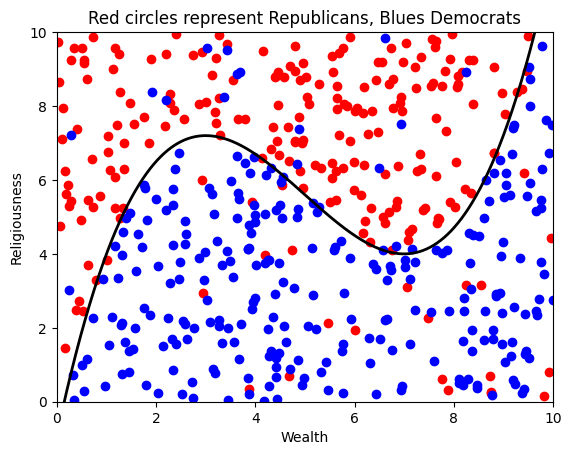

In [3]:
# Generate and visualize a sample dataset
X, y = generate_data(m=500)
plot_labeled_data(X, y)

## Analysis 1: Decision Boundary Visualization

This section analyzes how different values of $k$ affect the decision boundary of the kNN classifier. By visualizing decision boundaries for increasing $k$ values (1, 3, 5, 11, 21, 51, 99), the following observations can be made:

- How model complexity changes with $k$
- The smoothing effect of larger $k$ values
- The relationship between $k$ and overfitting/underfitting

The decision boundary visualization covers the range [0, 10] for both axes, with different colors representing regions classified as Republican (red) or Democrat (blue).



The analysis reveals how changes in the sample set affect the decision boundary as a function of k, identifies when the model underfits or overfits the data, and demonstrates how model complexity depends on $k$.

### Decision Boundary Visualization

Decision boundaries for multiple $k$ values are visualized simultaneously to compare their effects:

In [4]:
def plot_decision_boundary(knn: KNNClassifier):
    """
    Plots the decision boundary as contour line over a mesh grid on (0, 10)^2

    Parameters:
    X: np.ndarray
    Array of shape (n,2) is the feature set
    y: np.ndarray
    Array of shaoe (n,) contains model predictions
    """
    x_grid, y_grid = np.meshgrid(np.linspace(0, 10, 200), np.linspace(0, 10, 200))
    grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])
    predictions = knn.predict(grid_points).reshape(x_grid.shape)
    plt.contourf(x_grid, y_grid, predictions, alpha=0.8, cmap='coolwarm')

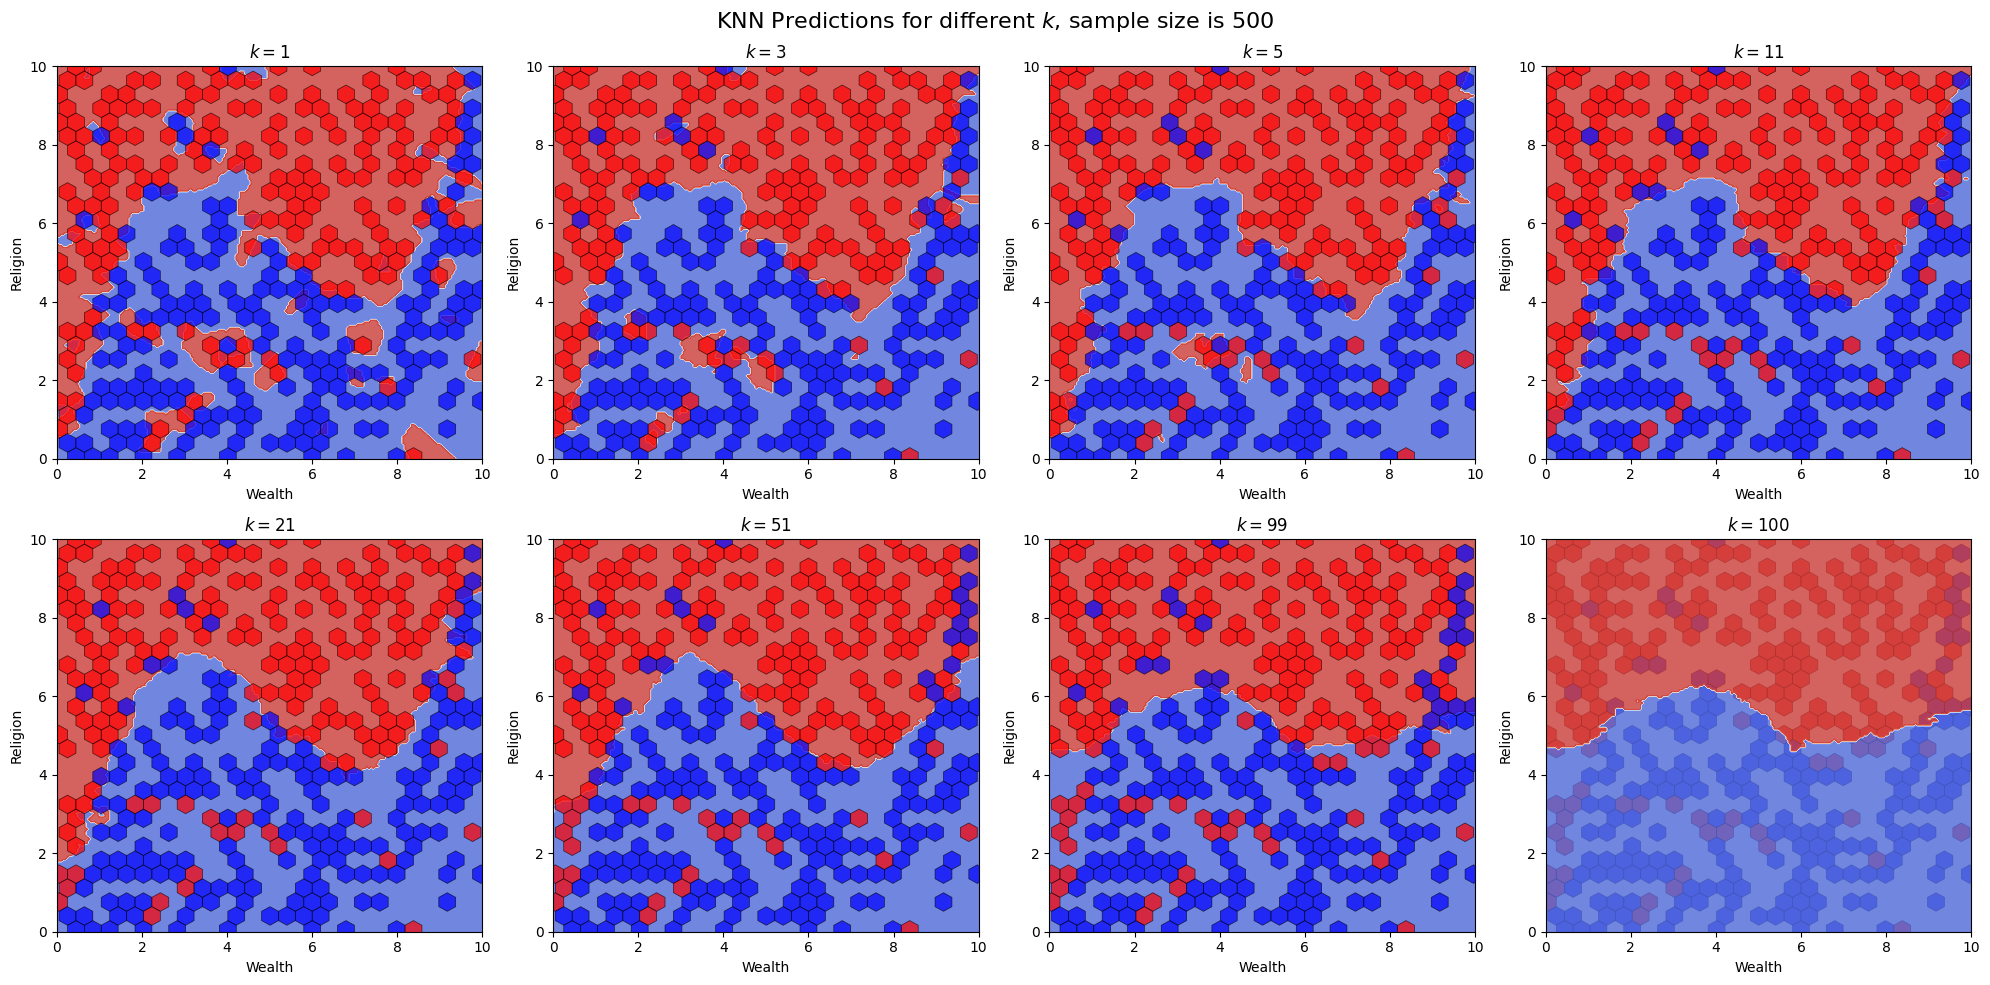

In [5]:
from matplotlib.colors import ListedColormap
from tqdm import tqdm

X_train, y_train = generate_data(m=500, seed=42)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, k in enumerate([1, 3, 5, 11, 21, 51, 99, 100]):
    knn = KNNClassifier(k_neighbors=k)
    knn.fit(X_train, y_train)

    plt.hexbin(X_train[:, 0], X_train[:, 1], C=y_train, gridsize=25, cmap=ListedColormap(["blue", "red"]), \
                                                                   edgecolors="black", linewidths=0.5, alpha=0.7)
    plt.sca(ax[i // 4, i % 4])
    plot_decision_boundary(knn)
    ax[i // 4, i % 4].set_title(fr"$k=${k}")
    ax[i // 4, i % 4].set_xlabel('Wealth')
    ax[i // 4, i % 4].set_ylabel('Religion')

fig.suptitle(r"KNN Predictions for different $k$, sample size is 500", fontsize=16)
plt.tight_layout()
plt.show();

### Analysis Results

**1. Sensitivity to Sample Changes:**
For a fixed sample size, changes to the training set affect the decision boundary **more** for smaller $k$. For larger $k$, the effect is much less noticeable since the decision boundary gets smoothed.

**2. Overfitting vs Underfitting:**
- **Small $k$ (e.g., $k=1$)**: The model overfits the data. With few neighbors, the classifier is sensitive to isolated outliers and noise, creating complex, irregular decision boundaries.
- **Large $k$ (e.g., $k=99$)**: The model underfits the data. With many neighbors, the decision boundary becomes overly smooth and may miss important patterns. In extreme cases, predictions tend toward the majority class.

**3. Model Complexity:**
- **Small $k$**: High model complexity - the model overfits on training data and is extremely sensitive to changes, even for outliers.
- **Large $k$**: Low model complexity - predictions are smoothed and generalized, but may lack the flexibility to capture local patterns.

**4. Computational Complexity:**
For each of $n$ test points:
- Calculate $n$ distances to training points: $O(n)$
- Partially sort distances up to $k$: $O(n\log k)$
- Calculate mode of $k$ neighbor labels: $O(k)$

Overall complexity: $O(n^2\log k)$ per prediction

### Additional Visualization: Decision Boundary Explorer

An interactive visualization demonstrates the effect of different $k$ values on the decision boundary:

In [6]:
from ipywidgets import interact

@interact(k=list(range(1, 101)))
def plot_decision_boundary_interactive(k: int):
    knn = KNNClassifier(k_neighbors=k)
    knn.fit(X_train, y_train)
    plt.hexbin(X_train[:, 0], X_train[:, 1], C=y_train, gridsize=25, cmap=ListedColormap(["blue", "red"]), \
                                                                   edgecolors="black", linewidths=0.5, alpha=0.7)
    plt.title(f"Decision boundary for k={k}")
    plot_decision_boundary(knn)
    return k



interactive(children=(Dropdown(description='k', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

## Analysis 2: Hyperparameter Optimization

The optimal $k$ value is systematically found by:

1. **Data Splitting**: Dividing a dataset of 1000 samples into:
   - Training set (60%): Used to fit the model
   - Validation set (20%): Used to select the best $k$
   - Test set (20%): Used for final evaluation (unseen during optimization)

2. **Error Analysis**: Plotting training vs validation error for $k$ values from 1 to 100

3. **Optimal Selection**: Using a relative overfit metric to find the best $k$ that balances bias and variance

4. **Generalization**: Evaluating the selected model on the test set to estimate true generalization error

This section compares what happens when optimizing directly on the test set (which would lead to overfitting to the test set) versus proper validation-based selection.

In [7]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns

X, y = generate_data(m=1000, seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5)

train_error, val_error, test_error = [], [], []
for k in tqdm(range(1, 101)):
    knn = KNNClassifier(k_neighbors=k)
    knn.fit(X_train, y_train)
    train_error.append(1.0 - knn.score(X_train, y_train))
    val_error.append(1.0 - knn.score(X_val, y_val))
    test_error.append(1.0 - knn.score(X_test, y_test))

100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


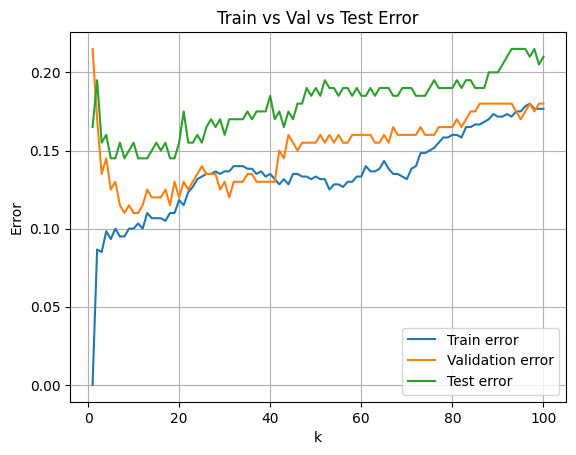

In [8]:
fig = plt.plot(figsize=(25,20))
sns.lineplot(x=range(1, 101), y=train_error, label='Train error')
sns.lineplot(x=range(1, 101), y=val_error, label='Validation error')
sns.lineplot(x=range(1, 101), y=test_error, label='Test error')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("Train vs Val vs Test Error")
plt.grid()
plt.show()

### Optimal k Selection Strategy

The optimal $k$ is where both validation and training errors are low and relatively close. A **relative overfit metric** is used to quantify this:

$$\text{Relative Overfit} = \frac{|\text{Val Err} - \text{Train Err}|}{\text{Val Err} + \text{Train Err}}$$

This metric helps identify the $k$ value that minimizes overfitting while maintaining good performance. The $k$ that minimizes this metric (first local minimum) is selected.

**Note**: If optimizing directly on the test set, the same metric would be used but with test error instead of validation error, which would lead to overfitting to the test set.

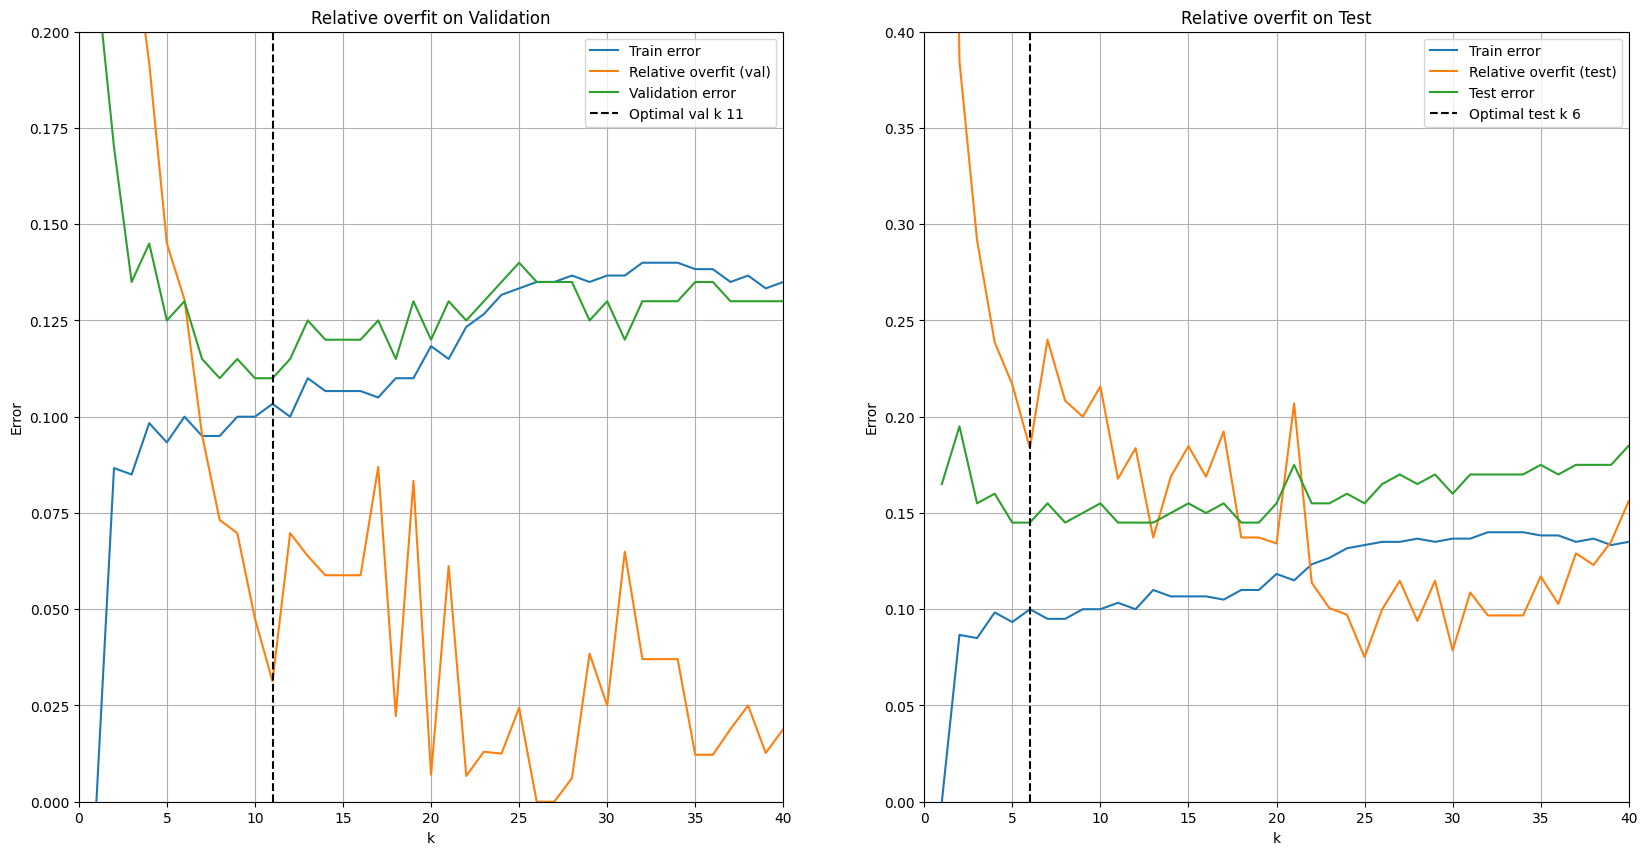

In [9]:
import pandas as pd
error_df = pd.DataFrame({"k": range(1, 101), "train_error": train_error, "val_error": val_error, \
                       "test_error": test_error})
error_df.set_index("k", inplace=True)
error_df["relative_overfit_val"] = np.abs(error_df.val_error - error_df.train_error) / (error_df.val_error + error_df.train_error)
error_df["relative_overfit_tst"] = np.abs(error_df.test_error - error_df.train_error) / (error_df.test_error + error_df.train_error)
optimal_k_val = error_df.relative_overfit_val[(error_df.relative_overfit_val.shift(1) > error_df.relative_overfit_val) & \
                                        (error_df.relative_overfit_val.shift(-1) > error_df.relative_overfit_val)].index[0]
optimal_k_tst = error_df.relative_overfit_tst[(error_df.relative_overfit_tst.shift(1) > error_df.relative_overfit_tst) & \
                                        (error_df.relative_overfit_tst.shift(-1) > error_df.relative_overfit_tst)].index[0]


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=range(1, 101), y=train_error, label='Train error', ax=ax[0])
sns.lineplot(error_df, x=error_df.index, y="relative_overfit_val", label="Relative overfit (val)", ax=ax[0])
sns.lineplot(x=range(1, 101), y=val_error, label='Validation error', ax=ax[0])
ax[0].axvline(x=optimal_k_val, label=f"Optimal val k {optimal_k_val}", linestyle='--', color='k')
ax[0].set_xlabel("k")
ax[0].set_ylabel("Error")
ax[0].set_title("Relative overfit on Validation")
ax[0].set_ylim(0, 0.2)
ax[0].set_xlim(0, 40)
ax[0].grid()
ax[0].legend()

sns.lineplot(x=range(1, 101), y=train_error, label='Train error', ax=ax[1])
sns.lineplot(error_df, x=error_df.index, y="relative_overfit_tst", label="Relative overfit (test)", ax=ax[1])
sns.lineplot(x=range(1, 101), y=test_error, label='Test error', ax=ax[1])
ax[1].axvline(x=optimal_k_tst, label=f"Optimal test k {optimal_k_tst}", linestyle='--', color='k')
ax[1].set_xlabel("k")
ax[1].set_ylabel("Error")
ax[1].set_title("Relative overfit on Test")
ax[1].set_ylim(0, 0.4)
ax[1].set_xlim(0, 40)
ax[1].grid()
ax[1].legend()

plt.show()

### Key Observations

**1. Training Error Behavior:**
As expected, training error is minimal when $k=1$ because the classifier overfits on the training data and predicts it nearly perfectly (each point is its own nearest neighbor).

**2. Generalization Gap:**
For $k=1$, validation and test errors are quite large because the model is overfit to the training data and struggles to generalize to new samples.

**3. Overfitting vs Underfitting:**
- **Small $k$**: Model overfits - low training error but high validation/test error
- **Large $k$**: Model underfits - both training and validation errors are high, but closer together

**4. Optimal Selection:**
The relative overfit metric $\frac{|\text{Val Err} - \text{Train Err}|}{\text{Val Err} + \text{Train Err}}$ is used, and the $k$ at its first local minimum is selected, which represents the best balance between bias and variance.

### Final Model Evaluation

Evaluating the optimal classifier (selected using validation set) on the test set to estimate true generalization error:

In [10]:
knn_opt = KNNClassifier(k_neighbors=optimal_k_val)
knn_opt.fit(X_train, y_train)
print(f"Test error for optimal val k = {optimal_k_val} is {round(1 - knn_opt.score(X_test, y_test), 3)}")

Test error for optimal val k = 11 is 0.145


### Comparison: Validation vs Test Optimization

If the relative overfit metric is optimized directly on the test set (which is incorrect practice), a different optimal $k=6$ is obtained. The test error for this approach is compared below:

In [11]:
knn_opt = KNNClassifier(k_neighbors=optimal_k_tst)
knn_opt.fit(X_train, y_train)
print(f"Test error for optimal test k = {optimal_k_tst} is {round(1 - knn_opt.score(X_test, y_test), 3)}")

Test error for optimal test k = 6 is 0.145


## Analysis 3: Cross-Validation for Robust Hyperparameter Selection

This section uses **5-fold cross-validation (CV)** for more robust hyperparameter selection:

1. **Data Splitting**: Set aside 20% as test set (unused until final evaluation)
2. **Cross-Validation**: Apply 5-fold CV on the remaining 80% of data
3. **CV Process**: In each fold, 80% of the CV data is used for training and 20% for validation
4. **Model Selection**: Select $k$ based on mean CV performance across all folds

**Advantages of Cross-Validation:**
- More robust than single validation set (reduces variance in performance estimates)
- Better use of available data (each sample is used for both training and validation across folds)
- Less prone to overfitting to a specific validation set split

**CV Process Details:**
In 5-fold cross-validation, each iteration uses 80% of the CV data for training (64% of total data) and 20% for validation (16% of total data). The validation set rotates across different portions of the data in each fold, providing a more robust estimate of model performance.

In [12]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

parameters = {'k_neighbors': list(range(1, 100))}
knn = KNNClassifier(k_neighbors=1)
clf = GridSearchCV(knn, param_grid=parameters, cv=5, verbose=1)
clf.fit(X_train, y_train)
cv_opt_k = clf.best_params_['k_neighbors']

Fitting 5 folds for each of 99 candidates, totalling 495 fits


Text(0.5, 1.0, '5-fold CV mean error')

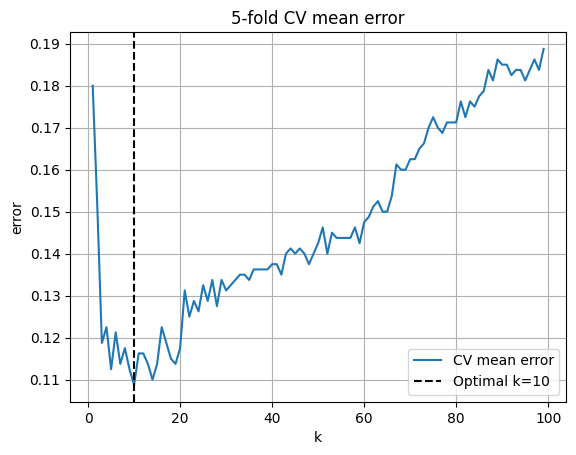

In [13]:
fig = plt.plot(figsize=(25, 15))
sns.lineplot(x=range(1, 100), y=1 - clf.cv_results_['mean_test_score'], label='CV mean error')
plt.xlabel("k")
plt.ylabel("error")
plt.axvline(x=cv_opt_k, linestyle='--', color='k', label=f"Optimal k={cv_opt_k}")
plt.grid()
plt.legend()
plt.title("5-fold CV mean error")

### Cross-Validation Results

**CV Process:**
In 5-fold cross-validation, each iteration uses:
- **Training**: 80% of the CV data (64% of total data)
- **Validation**: 20% of the CV data (16% of total data)
- The validation set rotates across different portions of the data in each fold

**Model Selection:**
The optimal $k$ changed to $k=10$ (compared to $k=11$ from single validation set). This change occurs because:

1. **Reduced Variance**: CV averages performance across multiple validation splits, reducing the variance in the performance estimate
2. **Less Overfitting**: CV prevents overfitting to a single validation set split
3. **More Robust**: The selected hyperparameter is more likely to generalize well to unseen data

**Key Insight**: Cross-validation provides a more reliable estimate of model performance and helps select hyperparameters that generalize better.

### Final Evaluation: CV-Optimized Model

Evaluating the cross-validation optimized model on the held-out test set:

In [14]:
knn_opt = KNNClassifier(k_neighbors=cv_opt_k)
knn_opt.fit(X_train, y_train)
print(f"Test error for optimal test k is {round(1 - knn_opt.score(X_test, y_test), 3)}")

Test error for optimal test k is 0.135


### Results Summary

The cross-validation optimized model achieves better test performance than the single validation set approach. This demonstrates the value of using cross-validation for hyperparameter selection, as it:

- Provides more robust performance estimates
- Reduces the risk of overfitting to a specific validation split
- Leads to better generalization to unseen test data

**Conclusion**: Cross-validation is a superior method for hyperparameter optimization, especially when dealing with limited data or when more reliable performance estimates are desired.

## References

- [Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html) - Scott Fortmann-Roe's comprehensive explanation
- [Measuring Error](http://scott.fortmann-roe.com/docs/MeasuringError.html) - Understanding different error metrics
- [Cross-Validation in scikit-learn](http://scikit-learn.org/stable/modules/cross_validation.html) - Official documentation
- [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - scikit-learn reference implementation
- [Nearest Neighbor Search](https://en.wikipedia.org/wiki/Nearest_neighbor_search) - Wikipedia article on efficient implementations
- [KD-Tree Implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html) - SciPy's kd-tree for efficient nearest neighbor search